In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GroupKFold,train_test_split,KFold
from sklearn.metrics import ndcg_score
from scipy.stats import uniform, randint, spearmanr, kendalltau, rankdata
from tqdm import tqdm

1/ LOAD DATA

In [17]:
#load main data without sponsored
df = pd.read_csv("C:/Users/Pierre-François/ChiChi's Research/ChiChi/full_organic.csv")
#load result from sentence-BERT (doing this seperately using unique asin to save computational time)
df_semantic = pd.read_csv("C:/Users/Pierre-François/ChiChi's Research/ChiChi/semantic.csv")

In [18]:
# drop dup + check data
df = df.drop_duplicates(subset=['asin', 'search_term', 'page_number', 'position', 'scrape_date', 'scrape_hour'], keep='first')
print(df.shape)
df.head(10)
df.columns

(1194473, 39)


Index(['Unnamed: 0', 'asin', 'search_term', 'page_number', 'position',
       'scrape_date', 'scrape_time', 'scrape_hour', 'title', 'price',
       'original_price', 'sponsored', 'reviews_count', 'rating',
       'sales_history', 'prime', 'brand', 'bsr_1', 'bsr_2', 'categories',
       'bullet_points', 'description', 'main_cat', 'sub_cat', 'main_cat_rank',
       'sub_cat_rank', 'sales_bucket', 'sales_badge', 'discount',
       'log_sub_rank', 'log_main_rank', 'log_price', 'log_review',
       'popularity', 'popularity_1', 'discount_group', 'group_id',
       'price_competitiveness', 'continuous_rank'],
      dtype='object')

In [20]:
# drop dup
df = df.drop_duplicates(subset=['asin', 'search_term', 'page_number', 'position', 'scrape_date', 'scrape_hour'], keep='first')
print(df.shape)
df.head(10)
df.columns

(1194473, 48)


Index(['Unnamed: 0', 'asin', 'search_term', 'page_number', 'position',
       'scrape_date', 'scrape_time', 'scrape_hour', 'title', 'price',
       'original_price', 'sponsored', 'reviews_count', 'rating',
       'sales_history', 'prime', 'brand', 'bsr_1', 'bsr_2', 'categories',
       'bullet_points', 'description', 'main_cat', 'sub_cat', 'main_cat_rank',
       'sub_cat_rank', 'sales_bucket', 'sales_badge', 'discount',
       'log_sub_rank', 'log_main_rank', 'log_price', 'log_review',
       'popularity', 'popularity_1', 'discount_group', 'group_id',
       'price_competitiveness', 'continuous_rank', 'semantic_title',
       'semantic_bullet', 'semantic_description', 'tf_bullet', 'tf_title',
       'tf_des', 'tf_idf_bullet', 'tf_idf_title', 'tf_idf_des'],
      dtype='object')

In [19]:
# merge the semantic similarity result with main data
df = df.merge(
    df_semantic[['asin', 'semantic_title', 'semantic_bullet', 'semantic_description','tf_bullet', 'tf_title', 'tf_des',
    'tf_idf_bullet', 'tf_idf_title', 'tf_idf_des']], 
    on='asin', 
    how='left'
)

print(f"Total rows in full data: {len(df)}")
print(f"ASINs with semantic data: {df['semantic_title'].notna().sum()}")
print(f"ASINs without semantic data: {df['semantic_title'].isna().sum()}")
print("\nexample:")
print(df[['asin', 'semantic_title', 'semantic_bullet', 'semantic_description']].head())

Total rows in full data: 1194473
ASINs with semantic data: 1194473
ASINs without semantic data: 0

example:
         asin  semantic_title  semantic_bullet  semantic_description
0  B093LVB4P7        0.583688         0.357817              0.461419
1  B07MLFBJG3        0.533498         0.452791              0.241498
2  B00LN803LE        0.441109         0.567591              0.435949
3  B00MNV8E0C        0.634450         0.524309              0.521388
4  B005640AW8        0.538975         0.393177              0.353753


2/ PREPROCESSING
To prepare for model, there are 4 components:
/ X : predictors - feature inputs
/ y : target - relevance lable created from actual rank
/ group id: unique identifier by query, scrape_date, scrape_hour 
/ qids : query id - unique identifier for each query


Actual rank is the adjusted rank after removing the sponsored product


In [ ]:
# create adjusting rank because sponsored result is excluded
# sort df by search_term, scrape_date, page_number, and position and the numbering it sequentially
df = df.sort_values(['search_term', 'scrape_date', 'scrape_hour','page_number', 'position'])
df['adjusted_rank'] = df.groupby(['search_term','scrape_date','scrape_hour']).cumcount() + 1
df = df.reset_index(drop=True)

In [24]:
# check the adjusted_rank
print("first 20 rows:")
print(df[['search_term', 'scrape_date', 'scrape_hour','page_number', 'position', 'adjusted_rank']].head(20))

first 20 rows:
     search_term scrape_date  scrape_hour  page_number  position  \
0   aa batteries  2025-03-21            0            1         5   
1   aa batteries  2025-03-21            0            1         6   
2   aa batteries  2025-03-21            0            1         7   
3   aa batteries  2025-03-21            0            1         8   
4   aa batteries  2025-03-21            0            1         9   
5   aa batteries  2025-03-21            0            1        10   
6   aa batteries  2025-03-21            0            1        11   
7   aa batteries  2025-03-21            0            1        12   
8   aa batteries  2025-03-21            0            1        13   
9   aa batteries  2025-03-21            0            1        14   
10  aa batteries  2025-03-21            0            1        15   
11  aa batteries  2025-03-21            0            1        16   
12  aa batteries  2025-03-21            0            1        17   
13  aa batteries  2025-03-21     

In [25]:
# check each search term and date
for search_term in df['search_term'].unique()[:3]:  # first 3 search terms
    term_data = df[df['search_term'] == search_term]
    for date in term_data['scrape_date'].unique()[:2]:  # first 2 dates
        date_data = term_data[term_data['scrape_date'] == date]
        print(f"\query: '{search_term}', Date: {date}")
        print(f"total results: {len(date_data)}")
        print(f"range: {date_data['adjusted_rank'].min()} to {date_data['adjusted_rank'].max()}")

\query: 'aa batteries', Date: 2025-03-21
total results: 1524
range: 1 to 141
\query: 'aa batteries', Date: 2025-03-22
total results: 1625
range: 1 to 139
\query: 'air fryer', Date: 2025-03-21
total results: 1357
range: 1 to 126
\query: 'air fryer', Date: 2025-03-22
total results: 1464
range: 1 to 123
\query: 'airpods', Date: 2025-03-21
total results: 1513
range: 1 to 139
\query: 'airpods', Date: 2025-03-22
total results: 1626
range: 1 to 138


In [ ]:
# create unique group identifier group_id by search_term, scrape_date, scrape_hour
df['group_id'] = df['search_term'].astype(str) + '_' + df['scrape_date'].astype(str) + '_' + df['scrape_hour'].astype(str)
df['group_id'] = df['group_id'].astype('category').cat.codes

# check the results
group_mapping = df[['group_id', 'search_term', 'scrape_date','scrape_hour']].drop_duplicates().sort_values('group_id')
print(f"unique groups: {df['group_id'].nunique()}")
print("\ngroup mapping:")
print(group_mapping.head(24))

unique groups: 8686

group mapping:
      group_id   search_term scrape_date  scrape_hour
0            0  aa batteries  2025-03-21            0
703          1  aa batteries  2025-03-21           10
840          2  aa batteries  2025-03-21           12
977          3  aa batteries  2025-03-21           14
1116         4  aa batteries  2025-03-21           16
1251         5  aa batteries  2025-03-21           18
140          6  aa batteries  2025-03-21            2
1387         7  aa batteries  2025-03-21           22
281          8  aa batteries  2025-03-21            4
422          9  aa batteries  2025-03-21            6
563         10  aa batteries  2025-03-21            8
1524        11  aa batteries  2025-03-22            0
2203        12  aa batteries  2025-03-22           10
2342        13  aa batteries  2025-03-22           12
2476        14  aa batteries  2025-03-22           14
2610        15  aa batteries  2025-03-22           16
2744        16  aa batteries  2025-03-22      

In [ ]:
# create relevance label per group_id
def bin_group(group):
    # invert the rank so that the lower value of rank the higher rank
    values = -group['adjusted_rank'].values
    
    # create bins within this query group
    bins = pd.qcut(values, q=min(5, len(group)), 
                   labels=range(1, min(5, len(group))+1),
                   duplicates='drop')
    group['relevance'] = bins.astype(int)
    return group

# apply the relevance
df = df.groupby('group_id', group_keys=False).apply(bin_group)

In [31]:
# check the relevance distribution
relevance_counts = df['relevance'].value_counts().sort_index()
print("label distribution:")
print(relevance_counts)
print(f"total items: {len(df)}")

label distribution:
relevance
1    242354
2    237002
3    237065
4    237002
5    241050
Name: count, dtype: int64
total items: 1194473


In [32]:
# create features matrix
df['prime'] = df['prime'].astype(int)
df['sponsored'] = df['sponsored'].astype(int)
df['popularity'] = df['popularity_1'].astype(int)
df['discount'] = df['discount'].astype(int)
df['sales_badge'] = df['sales_badge'].astype(int)

# feature columns
feature_cols = [
    # products page features
    'log_price', 'price_competitiveness',
    'log_review', 'rating','prime',
    'discount',
    # lexical similarity
    'tf_bullet', 'tf_title', 'tf_des',
    'tf_idf_bullet', 'tf_idf_title', 'tf_idf_des',
    'semantic_bullet', 'semantic_title', 'semantic_description',
    
    # sales signals
    'main_cat_rank','sub_cat_rank','sales_badge',
    
    # others
    'popularity'

]
feature_cols = [col for col in feature_cols if col in df.columns]

In [33]:
# final data for building model
X = df[feature_cols]
y = df['relevance'].values
group_ids = df['group_id'].values 
qids = df['search_term'].unique()
actual_ranks = df['adjusted_rank'].values

In [ ]:
3/ SPILTING DATA

In [34]:
# split by search term to test the model if they havent seen that query before
train_terms, test_terms = train_test_split(qids, test_size=0.2, random_state=42)
train_mask = df['search_term'].isin(train_terms)
test_mask = df['search_term'].isin(test_terms)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
group_ids_train = group_ids[train_mask]
group_ids_test = group_ids[test_mask]
actual_ranks_train = actual_ranks[train_mask]
actual_ranks_test = actual_ranks[test_mask]

print(f"train on {len(train_terms)} unique search terms")
print(f"test on {len(test_terms)} unique search terms")
print(f"traning samples: {len(X_train)}")
print(f"testing samples: {len(X_test)}")


train on 84 unique search terms
test on 22 unique search terms
traning samples: 946583
testing samples: 247890


In [35]:
# calculate group sizes
train_groups = np.bincount(group_ids_train)[np.nonzero(np.bincount(group_ids_train))[0]]
test_groups = np.bincount(group_ids_test)[np.nonzero(np.bincount(group_ids_test))[0]]

4/ MODELS + EVALUATION METRICS
/ nDCG@k
/ precision@k
/ avg rank@k

In [ ]:
# define function

def calculate_metrics_for_multiple_k(y_true, y_pred, actual_ranks, group_ids, k_values=[5, 10, 20, 30]):
    """NDCG@k and precision@k for model predictions for multiple k values"""
    # Make sure all arrays have the same length
    assert len(y_true) == len(y_pred) == len(actual_ranks) == len(group_ids), "All input arrays must have the same length"
    
    results = {}
    # Calculate metrics for each k value
    for k in k_values:
        ndcg_scores = []
        precision_at_k_values = []
        avg_rank_of_predictions = []
        unique_groups = np.unique(group_ids)
        
        for gid in unique_groups:
            mask = (group_ids == gid)
            if np.sum(mask) < 2:
                continue
                
            # get data of this group
            group_y_true = y_true[mask]
            group_y_pred = y_pred[mask]
            group_actual_ranks = actual_ranks[mask]
            
            # Adjust k if necessary
            k_value = min(k, len(group_y_true))
            
            # nDCG based on relevance scores
            y_true_reshaped = np.asarray([group_y_true])
            y_pred_reshaped = np.asarray([group_y_pred])
            ndcg = ndcg_score(y_true_reshaped, y_pred_reshaped, k=k_value)
            ndcg_scores.append(ndcg)
            
            # Calculate precision@k
            top_k_pred_indices = np.argsort(-group_y_pred)[:k_value]
            top_k_actual_indices = np.argsort(group_actual_ranks)[:k_value]
            
            precision = len(set(top_k_pred_indices) & set(top_k_actual_indices)) / k_value
            precision_at_k_values.append(precision)
            
            # Calculate average rank of top k predictions
            avg_rank = np.mean(group_actual_ranks[top_k_pred_indices])
            avg_rank_of_predictions.append(avg_rank)
        
        # Store metrics for this k value
        results[f'ndcg@{k}'] = np.mean(ndcg_scores) if ndcg_scores else 0
        results[f'precision@{k}'] = np.mean(precision_at_k_values) if precision_at_k_values else 0
        results[f'avg_rank@{k}'] = np.mean(avg_rank_of_predictions) if avg_rank_of_predictions else 0
    
    # Calculate Spearman and Kendall only once (k doesn't matter for these)
    spearman_correlations = []
    kendall_correlations = []
    
    for gid in np.unique(group_ids):
        mask = (group_ids == gid)
        if np.sum(mask) < 2:
            continue
            
        group_y_pred = y_pred[mask]
        group_actual_ranks = actual_ranks[mask]
        
        # predict ranks within this group
        predicted_ranks = rankdata(-group_y_pred, method='min')
        
        # correlation between predicted and actual ranks
        spearman_corr, _ = spearmanr(predicted_ranks, group_actual_ranks)
        kendall_corr, _ = kendalltau(predicted_ranks, group_actual_ranks)
        
        if not np.isnan(spearman_corr):
            spearman_correlations.append(spearman_corr)
        if not np.isnan(kendall_corr):
            kendall_correlations.append(kendall_corr)
    
    results['spearman'] = np.mean(spearman_correlations) if spearman_correlations else 0
    results['kendall'] = np.mean(kendall_correlations) if kendall_correlations else 0
    
    return results

In [37]:
## INITIAL RUNNING USING ONLY TOPK AND NDCG OBJECTIVES 

# cross validation
n_splits = 5
k_values = [5, 10, 20, 30]

print("Running cross-validation with basic model train-test split by search_term")   
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_results_baseline = []

for fold, (train_term_idx, val_term_idx) in enumerate(kf.split(qids)):
    train_terms = qids[train_term_idx]
    val_terms = qids[val_term_idx]
        
    # Create masks
    train_mask = df['search_term'].isin(train_terms)
    val_mask = df['search_term'].isin(val_terms)
        
    # Split data
    X_fold_train = X[train_mask]
    X_fold_val = X[val_mask]
    y_fold_train = y[train_mask]
    y_fold_val = y[val_mask]
    group_ids_fold_train = group_ids[train_mask]
    group_ids_fold_val = group_ids[val_mask]
    ranks_fold_val = actual_ranks[val_mask]
        
    # Sort training data by group_id
    sort_idx = np.argsort(group_ids_fold_train)
    X_fold_train_sorted = X_fold_train.iloc[sort_idx]
    y_fold_train_sorted = y_fold_train[sort_idx]
    group_ids_fold_train_sorted = group_ids_fold_train[sort_idx]
        
    # Calculate group sizes
    fold_train_groups = np.bincount(group_ids_fold_train_sorted)[np.nonzero(np.bincount(group_ids_fold_train_sorted))[0]]

    # MODEL
    model = xgb.XGBRanker(
        objective='rank:ndcg',
        tree_method='hist',
         lambdarank_pair_method="topk",
         lambdarank_num_pair_per_sample=10 #OPTIMIZE NDCG@5 > CHOSE THE BIGGER K THAN 5
    )
    model.fit(X_fold_train_sorted, y_fold_train_sorted, group=fold_train_groups)
    
    # Predict on validation fold
    y_pred_fold_val = model.predict(X_fold_val)
    
    # Calculate metrics for fold
    fold_metrics = calculate_metrics_for_multiple_k(y_fold_val, y_pred_fold_val, ranks_fold_val, group_ids_fold_val, k_values=k_values)
    
    # Store results for this fold
    fold_results = {'fold': fold}
    fold_results.update(fold_metrics)  # Add all metrics to results
    cv_results_baseline.append(fold_results)

# CV results
cv_df = pd.DataFrame(cv_results_baseline)
base_mean = cv_df.mean()
std_results = cv_df.std()

print("\nCV results:")
for metric in base_mean.index:
    print(f"{metric}: {base_mean[metric]:.4f} ± {std_results[metric]:.4f}")

# Calculate the average NDCG across all k values for baseline
baseline_ndcg_metrics = [base_mean[f'ndcg@{k}'] for k in k_values]
baseline_avg_ndcg = np.mean(baseline_ndcg_metrics)
print(f"\ninitial avg NDCG across all k values: {baseline_avg_ndcg:.4f}")

Running cross-validation with basic model train-test split by search_term

CV results:
fold: 2.0000 ± 1.5811
ndcg@5: 0.8803 ± 0.0140
precision@5: 0.3514 ± 0.0203
avg_rank@5: 27.0976 ± 2.3202
ndcg@10: 0.8589 ± 0.0167
precision@10: 0.4139 ± 0.0131
avg_rank@10: 31.7742 ± 2.5796
ndcg@20: 0.8268 ± 0.0120
precision@20: 0.4651 ± 0.0110
avg_rank@20: 38.6582 ± 1.5613
ndcg@30: 0.8073 ± 0.0112
precision@30: 0.5016 ± 0.0185
avg_rank@30: 43.7955 ± 1.8576
spearman: 0.4060 ± 0.0271
kendall: 0.2866 ± 0.0190

initial avg NDCG across all k values: 0.8433


In [ ]:
#  RANDOMIZED SEARCH TO TUNE MODEL WITH MORE PARAMETERS

# param dist 
param_distributions = {
    # xgboost parameters
    'learning_rate': uniform(0.01, 0.29),          
    'max_depth': randint(3, 15),                  
    'n_estimators': randint(50, 300),            
    'subsample': uniform(0.5, 0.5),             
    'colsample_bytree': uniform(0.5, 0.5),       
    'min_child_weight': randint(1, 10),          
    'gamma': uniform(0, 1),                  
    # LambdaMART parameters
    'lambdarank_num_pair_per_sample': [8, 16, 32],  
    'lambdarank_pair_method': ['topk', 'mean'],       
}

# iteration
n_iter = 30  
n_splits = 5
np.random.seed(42)

# set the score
best_score = -float('inf')
best_params = None
all_results = []

print("start search")
for i in tqdm(range(n_iter)):
    params = {
        # xgboost parameters
        'learning_rate': param_distributions['learning_rate'].rvs(),
        'max_depth': param_distributions['max_depth'].rvs(),
        'n_estimators': param_distributions['n_estimators'].rvs(),
        'subsample': param_distributions['subsample'].rvs(),
        'colsample_bytree': param_distributions['colsample_bytree'].rvs(),
        'min_child_weight': param_distributions['min_child_weight'].rvs(),
        'gamma': param_distributions['gamma'].rvs(),
        
        # LambdaMART parameters
        'lambdarank_num_pair_per_sample': np.random.choice(param_distributions['lambdarank_num_pair_per_sample']),
        'lambdarank_pair_method': np.random.choice(param_distributions['lambdarank_pair_method']),
    }
    
    # CV
    cv_ndcg_values = []
    
    for fold, (train_term_idx, val_term_idx) in enumerate(kf.split(qids)):
        train_terms = qids[train_term_idx]
        val_terms = qids[val_term_idx]
            
        # masks
        train_mask = df['search_term'].isin(train_terms)
        val_mask = df['search_term'].isin(val_terms)
            
        # spkit
        X_fold_train = X[train_mask]
        X_fold_val = X[val_mask]
        y_fold_train = y[train_mask]
        y_fold_val = y[val_mask]
        group_ids_fold_train = group_ids[train_mask]
        group_ids_fold_val = group_ids[val_mask]
        ranks_fold_val = actual_ranks[val_mask]
            
        # sort by group id
        sort_idx = np.argsort(group_ids_fold_train)
        X_fold_train_sorted = X_fold_train.iloc[sort_idx]
        y_fold_train_sorted = y_fold_train[sort_idx]
        group_ids_fold_train_sorted = group_ids_fold_train[sort_idx]
            
        # group sizes
        fold_train_groups = np.bincount(group_ids_fold_train_sorted)[np.nonzero(np.bincount(group_ids_fold_train_sorted))[0]]

        # train model
        model = xgb.XGBRanker(objective='rank:ndcg', **params)
        model.fit(X_fold_train_sorted, y_fold_train_sorted, group=fold_train_groups)
        
        # predict and evaluate
        y_pred = model.predict(X_fold_val)
        
        # multiple metrics
        metrics = calculate_metrics_for_multiple_k(y_fold_val, y_pred, ranks_fold_val, group_ids_fold_val, k_values=k_values)
        
        # average NDCG across all k values
        ndcg_values = [metrics[f'ndcg@{k}'] for k in k_values]
        avg_ndcg = np.mean(ndcg_values)
        cv_ndcg_values.append(avg_ndcg)

    mean_score = np.mean(cv_ndcg_values)
    std_score = np.std(cv_ndcg_values)
    
    # Print progress every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Current best score: {best_score:.4f}")
    
    # Store results
    result = {
        'params': params,
        'mean_score': mean_score,
        'std_score': std_score
    }
    all_results.append(result)
    
    # Update best parameters if better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"new best score at iteration {i}: {best_score:.4f}")

<!-- # After all iterations, print summary
print(f"\nBest average NDCG score found: {best_score:.4f}")
print(f"Best parameters: {best_params}")

# Compare with baseline
print(f"\nComparison with baseline:")
print(f"Baseline average NDCG: {baseline_avg_ndcg:.4f}")
print(f"Best model average NDCG: {best_score:.4f}")
print(f"Improvement: {best_score - baseline_avg_ndcg:.4f} ({(best_score - baseline_avg_ndcg) / baseline_avg_ndcg * 100:.2f}%)")

# Sort all results by score for additional analysis
sorted_results = sorted(all_results, key=lambda x: x['mean_score'], reverse=True)
print("\nTop 5 parameter sets:")
for i, result in enumerate(sorted_results[:5]):
    print(f"Rank {i+1}: Score {result['mean_score']:.4f} ± {result['std_score']:.4f}")
    print(f"Parameters: {result['params']}\n") -->

In [ ]:
# print summary
print(f"best average NDCG score found: {best_score:.4f}")
print(f"best parameters: {best_params}")

# Compare with baseline
print(f"compare with initial model:")
print(f"initial dcg: {baseline_avg_ndcg:.4f}")
print(f"best model ndcg: {best_score:.4f}")
print(f"improve: {best_score - baseline_avg_ndcg:.4f} ({(best_score - baseline_avg_ndcg) / baseline_avg_ndcg * 100:.2f}%)")

<!-- # Best average NDCG score found: 0.8589
# Best parameters: {'learning_rate': np.float64(0.18586442730128108), 'max_depth': 5, 'n_estimators': 161, 'subsample': np.float64(0.5507357714330161), 'colsample_bytree': np.float64(0.8317508845540279), 'min_child_weight': 2, 'gamma': np.float64(0.16080805141749865), 'lambdarank_num_pair_per_sample': np.int64(16), 'lambdarank_pair_method': np.str_('mean')}
# Comparison with baseline:
# Baseline average NDCG: 0.8433
# Best model average NDCG: 0.8589
# Improvement: 0.0156 (1.85%) -->

In [40]:
cv_results_best = []
# CV best model
for fold, (train_term_idx, val_term_idx) in enumerate(kf.split(qids)):
    train_terms = qids[train_term_idx]
    val_terms = qids[val_term_idx]
        
    # masks
    train_mask = df['search_term'].isin(train_terms)
    val_mask = df['search_term'].isin(val_terms)
        
    # split
    X_fold_train = X[train_mask]
    X_fold_val = X[val_mask]
    y_fold_train = y[train_mask]
    y_fold_val = y[val_mask]
    group_ids_fold_train = group_ids[train_mask]
    group_ids_fold_val = group_ids[val_mask]
    ranks_fold_val = actual_ranks[val_mask]
        
    # sort by group id
    sort_idx = np.argsort(group_ids_fold_train)
    X_fold_train_sorted = X_fold_train.iloc[sort_idx]
    y_fold_train_sorted = y_fold_train[sort_idx]
    group_ids_fold_train_sorted = group_ids_fold_train[sort_idx]
        
    # group sizes
    fold_train_groups = np.bincount(group_ids_fold_train_sorted)[np.nonzero(np.bincount(group_ids_fold_train_sorted))[0]]

    model_best = xgb.XGBRanker(
        objective='rank:ndcg',
        learning_rate=0.18586442730128108,
        max_depth=5,
        n_estimators=161,
        subsample=0.5507357714330161,
        colsample_bytree=0.8317508845540279,
        min_child_weight=2,
        gamma=0.16080805141749865,
        lambdarank_num_pair_per_sample=16,
        lambdarank_pair_method='mean',
        tree_method='hist'
    )
    model_best.fit(X_fold_train_sorted, y_fold_train_sorted, group=fold_train_groups)
    
    # predict on validation fold
    y_pred_best = model_best.predict(X_fold_val)
    
    # metrics for fold
    fold_metrics = calculate_metrics_for_multiple_k(y_fold_val, y_pred_best, ranks_fold_val, group_ids_fold_val, k_values=k_values)
    
    # store results for this fold
    fold_results = {'fold': fold}
    fold_results.update(fold_metrics)  # Add all metrics to results
    cv_results_best.append(fold_results)

# CV results
cv_df_best = pd.DataFrame(cv_results_best)
mean_best = cv_df_best.mean()
std_results_best = cv_df_best.std()

print("CV results:")
for metric in mean_best.index:
    print(f"{metric}: {mean_best[metric]:.4f} ± {std_results_best[metric]:.4f}")

# avg ndcg across all k values for baseline
ndcg_metrics_best = [mean_best[f'ndcg@{k}'] for k in k_values]
avg_ndcg_best = np.mean(ndcg_metrics_best)
print(f"\nbest: {avg_ndcg_best:.4f}")

CV results:
fold: 2.0000 ± 1.5811
ndcg@5: 0.8988 ± 0.0120
precision@5: 0.3472 ± 0.0293
avg_rank@5: 24.3661 ± 1.7450
ndcg@10: 0.8739 ± 0.0122
precision@10: 0.4190 ± 0.0286
avg_rank@10: 29.8305 ± 1.9758
ndcg@20: 0.8401 ± 0.0116
precision@20: 0.4745 ± 0.0251
avg_rank@20: 36.9220 ± 1.9351
ndcg@30: 0.8230 ± 0.0137
precision@30: 0.5245 ± 0.0284
avg_rank@30: 41.5808 ± 2.1439
spearman: 0.4441 ± 0.0294
kendall: 0.3144 ± 0.0222

best: 0.8589


In [48]:
# PER QUERY PERFORMANCE
cv_results_best = []
keyword_metrics = {}

for fold, (train_term_idx, val_term_idx) in enumerate(kf.split(qids)):
    train_terms = qids[train_term_idx]
    val_terms = qids[val_term_idx]
        
    # masks
    train_mask = df['search_term'].isin(train_terms)
    val_mask = df['search_term'].isin(val_terms)
        
    # split
    X_fold_train = X[train_mask]
    X_fold_val = X[val_mask]
    y_fold_train = y[train_mask]
    y_fold_val = y[val_mask]
    group_ids_fold_train = group_ids[train_mask]
    group_ids_fold_val = group_ids[val_mask]
    ranks_fold_val = actual_ranks[val_mask]
    
    # get query
    val_search_terms = df.loc[val_mask, 'search_term'].values
        
    # sort training data by group_id
    sort_idx = np.argsort(group_ids_fold_train)
    X_fold_train_sorted = X_fold_train.iloc[sort_idx]
    y_fold_train_sorted = y_fold_train[sort_idx]
    group_ids_fold_train_sorted = group_ids_fold_train[sort_idx]
        
    # group sizes
    fold_train_groups = np.bincount(group_ids_fold_train_sorted)[np.nonzero(np.bincount(group_ids_fold_train_sorted))[0]]

    # using the best parameters
    model_best = xgb.XGBRanker(
        objective='rank:ndcg',
        learning_rate=0.18586442730128108,
        max_depth=5,
        n_estimators=161,
        subsample=0.5507357714330161,
        colsample_bytree=0.8317508845540279,
        min_child_weight=2,
        gamma=0.16080805141749865,
        lambdarank_num_pair_per_sample=16,
        lambdarank_pair_method='mean',
        tree_method='hist'
    )
    model_best.fit(X_fold_train_sorted, y_fold_train_sorted, group=fold_train_groups)
    
    # predict on validation fold
    y_pred_best = model_best.predict(X_fold_val)
    
    # metrics for fold
    fold_metrics = calculate_metrics_for_multiple_k(y_fold_val, y_pred_best, ranks_fold_val, group_ids_fold_val, k_values=k_values)
    
    # store results for this fold
    fold_results = {'fold': fold}
    fold_results.update(fold_metrics) 
    cv_results_best.append(fold_results)

    for search_term in np.unique(val_search_terms):
        # Filter validation data for this search term
        term_mask = val_search_terms == search_term
        
        # Skip if too few documents for this term
        if np.sum(term_mask) < 5:
            continue
            
        y_term = y_fold_val[term_mask]
        y_pred_term = y_pred_best[term_mask]
        group_ids_term = group_ids_fold_val[term_mask]
        ranks_term = ranks_fold_val[term_mask]
        
        if search_term not in keyword_metrics:
            keyword_metrics[search_term] = {
                'count': 0,
                'ndcg_values': {k: [] for k in k_values},
                'precision_values': {k: [] for k in k_values},
                'avg_ranks': {k: [] for k in k_values} 
            }
        
        # Update document count for this term
        keyword_metrics[search_term]['count'] += np.sum(term_mask)
        
        term_ndcg_metrics = calculate_metrics_for_multiple_k(y_term, y_pred_term, ranks_term, group_ids_term, k_values=k_values)
        
        # Store NDCG values
        for k in k_values:
            keyword_metrics[search_term]['ndcg_values'][k].append(term_ndcg_metrics[f'ndcg@{k}'])
            keyword_metrics[search_term]['precision_values'][k].append(term_ndcg_metrics[f'precision@{k}'])
            keyword_metrics[search_term]['avg_ranks'][k].append(term_ndcg_metrics[f'avg_rank@{k}'])


In [51]:
# Process per-keyword metrics into a DataFrame
keyword_results = []

for term, metrics in keyword_metrics.items():
    term_result = {'search_term': term, 'count': metrics['count']}
    
    # Calculate average rank for each k value
    for k in k_values:
        if k in metrics['avg_ranks'] and metrics['avg_ranks'][k]:
            term_result[f'avg_rank@{k}'] = np.mean(metrics['avg_ranks'][k])
        else:
            term_result[f'avg_rank@{k}'] = np.nan
    
    # Calculate average NDCG for each k value
    for k in k_values:
        if metrics['ndcg_values'][k]:
            term_result[f'ndcg@{k}'] = np.mean(metrics['ndcg_values'][k])
        else:
            term_result[f'ndcg@{k}'] = np.nan
    
    # Calculate average precision for each k value
    for k in k_values:
        if metrics['precision_values'][k]:
            term_result[f'precision@{k}'] = np.mean(metrics['precision_values'][k])
        else:
            term_result[f'precision@{k}'] = np.nan
    
    # Calculate average NDCG and precision across k values
    ndcg_values = [term_result[f'ndcg@{k}'] for k in k_values if f'ndcg@{k}' in term_result and not np.isnan(term_result[f'ndcg@{k}'])]
    precision_values = [term_result[f'precision@{k}'] for k in k_values if f'precision@{k}' in term_result and not np.isnan(term_result[f'precision@{k}'])]
    avg_rank_values = [term_result[f'avg_rank@{k}'] for k in k_values if f'avg_rank@{k}' in term_result and not np.isnan(term_result[f'avg_rank@{k}'])]
    
    if ndcg_values:
        term_result['avg_ndcg'] = np.mean(ndcg_values)
    else:
        term_result['avg_ndcg'] = np.nan
        
    if precision_values:
        term_result['avg_precision'] = np.mean(precision_values)
    else:
        term_result['avg_precision'] = np.nan
        
    if avg_rank_values:
        term_result['avg_rank'] = np.mean(avg_rank_values)
    else:
        term_result['avg_rank'] = np.nan
    
    keyword_results.append(term_result)

# Create DataFrame of keyword results
keyword_df = pd.DataFrame(keyword_results)
print(keyword_df)

      search_term  count  avg_rank@5  avg_rank@10  avg_rank@20  avg_rank@30  \
0    aa batteries  11095    7.041463    10.176829    30.901220    39.790650   
1      baby wipes  11052   10.663415    10.363415    14.818902    27.076829   
2        creatine  11089    7.912195    10.371951    16.744512    23.224390   
3           crocs  10670    7.856098    23.750000    33.681707    41.315447   
4    dehumidifier  11586    6.575610    23.778049    37.570122    50.493089   
..            ...    ...         ...          ...          ...          ...   
101    trash bags  11251   17.478049    20.128049    21.564024    33.081707   
102      umbrella  11542    9.931707    26.860976    37.125000    41.063821   
103       usb hub  11777   14.504878    18.395122    30.993902    36.364634   
104     vitamin d  11725   25.900000    26.771951    38.082317    38.960163   
105      xbox one  10678   44.814634    57.864634    65.775000    60.971545   

       ndcg@5   ndcg@10   ndcg@20   ndcg@30  precis

In [52]:
# save csv for table
keyword_df.to_csv("best_model_keyword_performance.csv")

5/ FEATURE IMPORTANCE
/ XGB Gain
/ SHAP

top 10 most important features:
                  Feature  Importance
16           sub_cat_rank    0.355288
15          main_cat_rank    0.168958
13         semantic_title    0.066115
2              log_review    0.060733
17            sales_badge    0.043938
3                  rating    0.042492
5                discount    0.034154
11             tf_idf_des    0.031986
1   price_competitiveness    0.030435
12        semantic_bullet    0.026600
plot importance analysis...


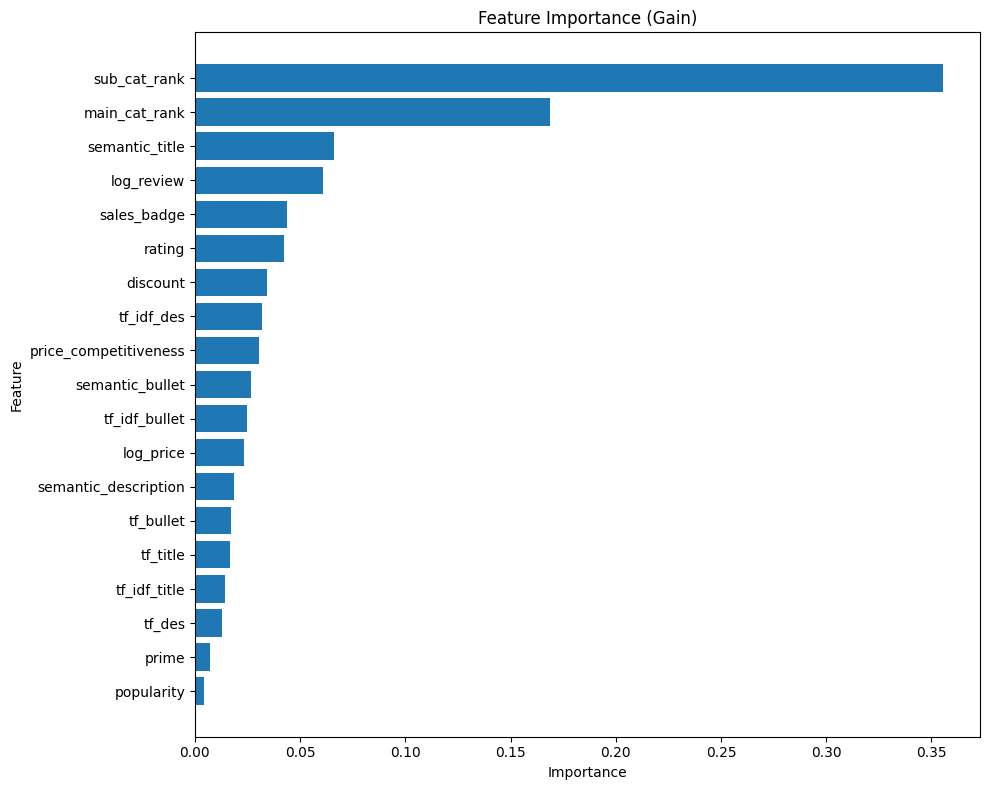

In [61]:
# XGBoost feature importance
feature_importances = model_best.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance':feature_importances})

importance_df = importance_df.sort_values('Importance', ascending=False)

# display results
print("top 10 most important features:")
print(importance_df.head(10))

# to csv
importance_df.to_csv("xgb_fi_csv")

print("plot importance analysis...")
# plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# SHAP feature importance
# use the TreeExplainer
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_test)



# SHAP summary plot with dot plot
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Value Distribution by Feature")
plt.tight_layout()
plt.show()

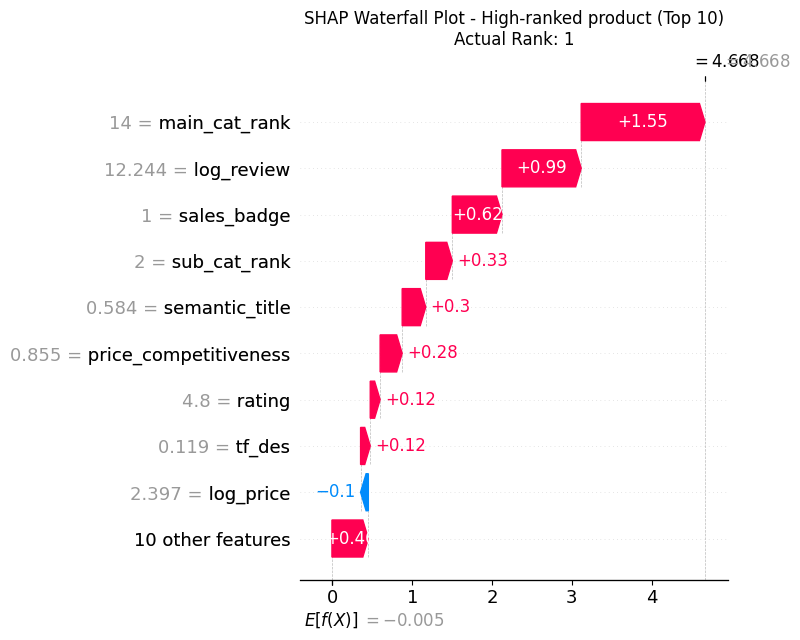

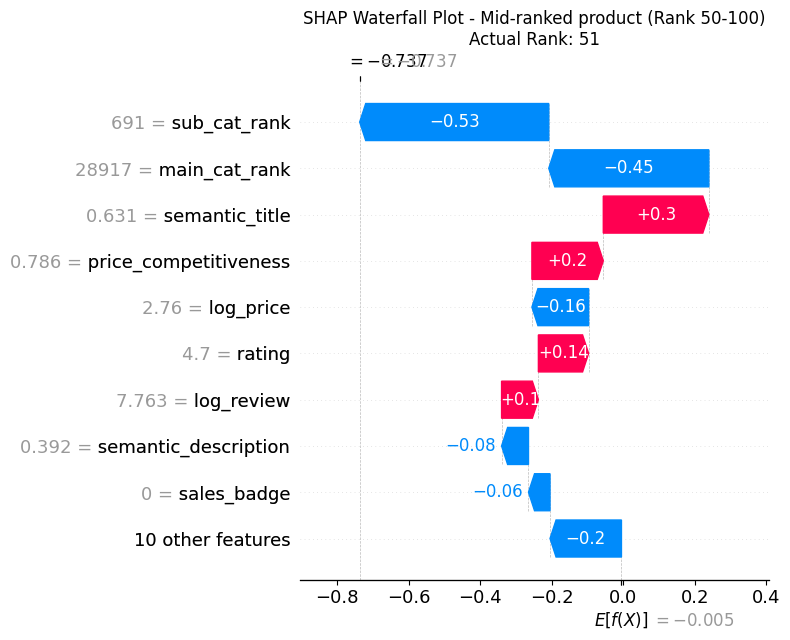

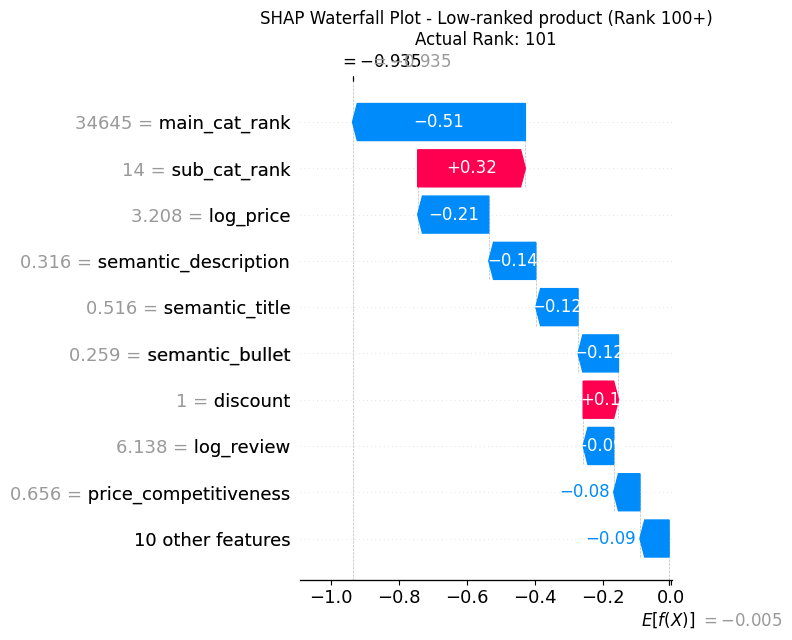

In [ ]:
# break rank into different group
high_rank_idx = np.where(actual_ranks_test <= 10)[0][0]  # High-ranked product
mid_rank_idx = np.where((actual_ranks_test > 50) & (actual_ranks_test <= 100))[0][0]  # Mid-ranked product
low_rank_idx = np.where(actual_ranks_test > 100)[0][0]  # Low-ranked product

# waterfall plots for different ranking
instances_to_plot = [
    (high_rank_idx, "High-ranked product (Top 10)"),
    (mid_rank_idx, "Mid-ranked product (Rank 50-100)"),
    (low_rank_idx, "Low-ranked product (Rank 100+)")
]

for idx, title in instances_to_plot:
    shap_explanation = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[idx].values,
        feature_names=feature_cols
    )
    
    # Create waterfall plot
    plt.figure(figsize=(14, 6))
    shap.waterfall_plot(shap_explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot - {title}\nActual Rank: {actual_ranks_test[idx]}")
    plt.tight_layout()
    plt.show()